<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod2/cmte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod2/cmte.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>


__Classification__

_homl3 ch3_

- MNIST - a dataset of handwritten digits
- Building a digit recognizer
- Model evaluation
  - Measuring Accuracy Using Cross-Validation
  - Confusion Matrices
  - Precision and Recall
  - The Precision/Recall Trade-off
  - The ROC Curve
- Multiclass Classification
  - Error Analysis
- Multilabel Classification
- Multioutput Classification

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

[MNIST - a dataset of handwritten digits](https://en.wikipedia.org/wiki/MNIST_database)
---
- Modified National Institute of Standards and Technology database (MNIST)
- a large database of handwritten digits used by image processing systems
- contains 70,000 black and white images 
  - 60,000 for training and 10,000 for testing
- each image is normalized to fit into a 28x28 pixel bounding box and anti-aliased

In [3]:
# fetch the dataset from https://www.openml.org/
mnist = skds.fetch_openml('mnist_784', as_frame=False, parser='auto')

# the returned if of type sklearn.utils.Bunch
# this is a dictionary whose keys can also be accessed as attributes
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# the description of the dataset
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X,y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

(<matplotlib.image.AxesImage at 0x7fc9cbf73910>, '0')

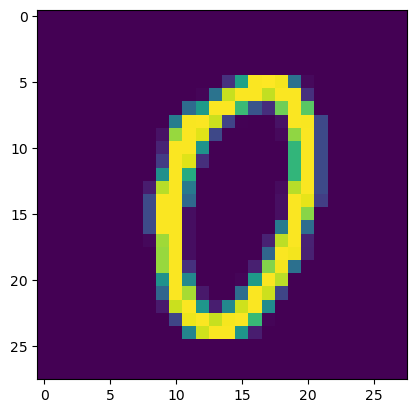

In [5]:
plt.imshow(X[1000].reshape((28,28))), y[1000]

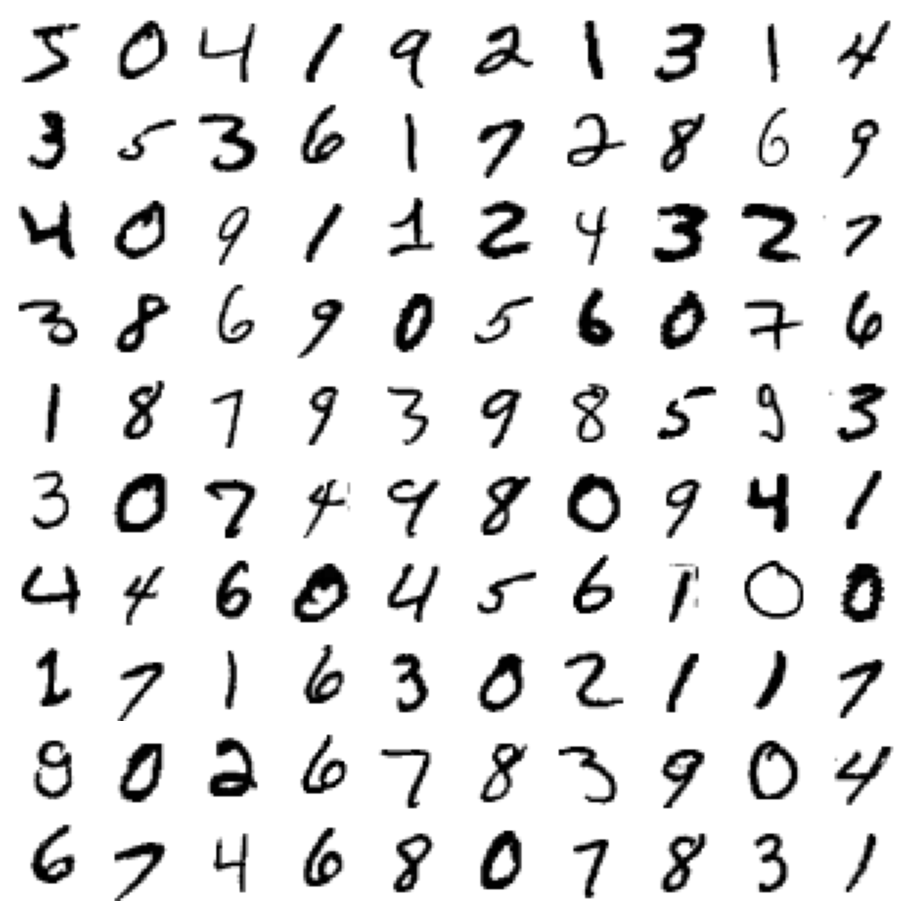

In [6]:
fig, axs=plt.subplots(10,10,figsize=(9,9), layout='constrained')
first_100_digits = X[:100]
for idx, dimg in enumerate(first_100_digits):
  axs[idx//10, idx%10].imshow(dimg.reshape((28,28)), cmap='binary')
  axs[idx//10, idx%10].axis("off")


In [7]:
# The dataset is already shuffled and split into a training set and a test set
X_train, y_train = X[:60_000], y[:60_000]
X_test, y_test = X[60_000:], y[60_000:]
# 👍 Thumb rule for data splitting: 80% for training 20% for testing

Building a digit recognizer
---
- Let's start from recognizing a single digit such as
  - `0` or `non-0`, `8` or `non-8`
  - which is a binary classifier
- can be implemented with many scikit-learn's classifiers, e.g.
  - stochastic gradient descent (SGD, or stochastic GD) classifier
  - implemented in the scikit-learn's SGDClassifier class

In [8]:
# create and train a binary classifier to recognize 8
from sklearn.linear_model import SGDClassifier
clfSgd = SGDClassifier(random_state=50)
y_train_8 = (y_train == '8')
clfSgd.fit(X_train, y_train_8)

SGDClassifier(random_state=50)

In [9]:
# recognize 8 from test images using this classifier
res = clfSgd.predict(first_100_digits[:100])
res.reshape((10,10))

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False,  True, False, False, False, False, False,  True, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False,  True, False, False, False, False, False, False, False,
        False],
       [False,  True, False, False, False, False,  True, False, False,
        False],
       [False, False, False, False, False,  True, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False,  True, False, False, False,
        False],
       [False, False, False, False,  True, False, False,  True, False,
        False]])

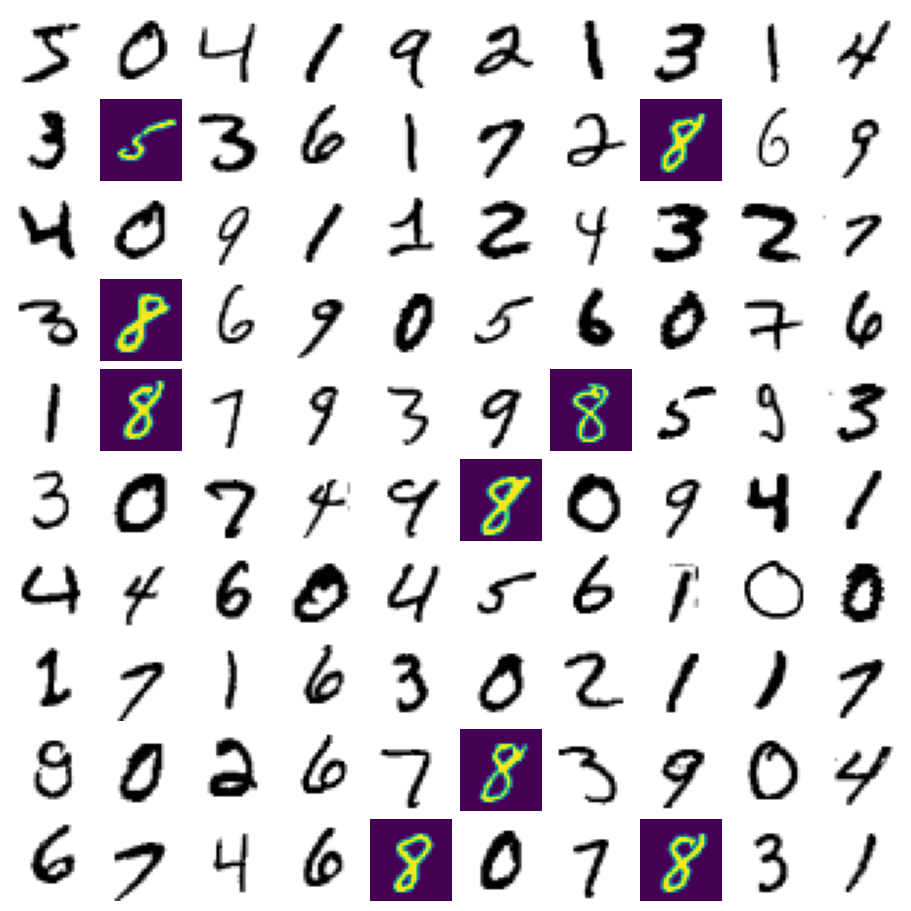

In [10]:
fig1, axs1=plt.subplots(10,10,figsize=(9,9), layout='constrained')
for idx, dimg in enumerate(first_100_digits[:100]):
  axs1[idx//10, idx%10].imshow(dimg.reshape((28,28)), cmap='binary') if res[idx] == False else axs1[idx//10, idx%10].imshow(dimg.reshape((28,28)))
  axs1[idx//10, idx%10].axis("off")

[Model evaluation](https://scikit-learn.org/stable/model_selection.html)
---
- many metrics are available for model evaluation, such as
  - confusion matrix
  - accuracy, precision, recall, f1 score, etc.
- which metrics are preferred depends on the requirements

Measuring Accuracy Using Cross-Validation
---
- k-fold cross-validation
  - split the training set into k folds
  - train the model k times
  - hold out a different fold each time for evaluation
  - implemented with cross_val_score in scikit

accuracy=(# of correct predictions)/(# of all predictions)


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(clfSgd, X_train, y_train_8, cv=5, scoring='accuracy') # cv=5 number of folds, default 5

array([0.91625   , 0.89841667, 0.93691667, 0.92841667, 0.92725   ])

In [12]:
# The accuracies are quite good for all folds. 
# However, this is caused by the imbalance of the chosen data.
# by just telling not-8 every time, we get 90% right
1-len(y_train_8[y_train_8 == True])/len(y_train_8)

0.9024833333333333

In [13]:
# equally randomly guess imbalanced data achieves high accuracy
# so accuracy is NOT useful in situations with highly imbalanced data
from sklearn.dummy import DummyClassifier
clfDummy = DummyClassifier()
clfDummy.fit(X_train, y_train_8)
cross_val_score(clfDummy, X_train, y_train_8, scoring='accuracy')

array([0.9025    , 0.9025    , 0.9025    , 0.9025    , 0.90241667])

In [14]:
# an implementation of cross-validation
# 5 folds

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skFolder = StratifiedKFold(n_splits=5, shuffle=True)
for trainIndex, testIndex in skFolder.split(X_train, y_train_8):
  cloneClf = clone(clfSgd)
  X_trainFold = X_train[trainIndex]
  y_trainFold = y_train_8[trainIndex]
  X_testFold = X_train[testIndex]
  y_testFold = y_train_8[testIndex]

  cloneClf.fit(X_trainFold, y_trainFold)
  yPred = cloneClf.predict(X_testFold)
  nCorrect = sum(yPred == y_testFold)
  print(nCorrect/len(yPred), end=" ")

0.9465 0.9356666666666666 0.9395833333333333 0.9438333333333333 0.9373333333333334 

[Confusion Matrices](https://en.wikipedia.org/wiki/Confusion_matrix)
---
- visualize of the performance of algorithms
- show number of misclassifications

| Actual\Prediction | non-`8` | `8` |
|:---:|:---:|:---:|
| non-`8` | True negative (TN) | False positive (FP)<br>or type I error |
| `8` | False negative (FN)<br>or type II error | True positive (TP) |

- $TN$: the number of correct (true) predictions of telling non-`8` as non-`8` (negative) 
- $FP$: the number of incorrect (false) predictions of telling non-`8` as `8` (positive)
- $FN$: the number of incorrect (false) predictions of telling `8` as non-`8` (negative)
- $TP$: the number of correct (true) predictions fo telling `8` as `8`
- $P=TP+FN$: the total number of `8`
- $N=TN+FP$: the total number of non-`8`

In [15]:
# generate the confusion matrix on training data
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(clfSgd, X_train, y_train_8)
cm = confusion_matrix(y_train_8, y_train_pred)

In [16]:
cm

array([[51964,  2185],
       [ 2528,  3323]])

Precision, recall and F1 score
---

- the precision of the classifier is the accuracy of the positive predictions
  - also called *positive predictive value*


$\displaystyle precision=\frac{TP}{TP+FP}$

- could be misleading in the case like
  - always make negative predictions
  - make only one positive prediction on the instance it is sure about
  - then, precision = 1/1 = 100%
- so, precision is usually used along with *recall*
  - also called *sensitivity*, or *true positive rate (TPR)*
  - i.e. the ratio of positive instances correctly predicted by the classifier

$\displaystyle recall=\frac{TP}{TP+FN}$

- Accuracy can be calculated as

$\displaystyle accuracy = \frac{TP+TN}{P+N}=\frac{TP+TN}{TP+TN+FP+FN}$

In [17]:
# calculate precision and recall
from sklearn.metrics import precision_score, recall_score, accuracy_score
tn,fp,fn,tp = cm.flatten()
print(f'precision=TP/(TP+FP)={tp}/({tp}+{fp})={tp/(tp+fp)}={precision_score(y_train_8,y_train_pred)}')
print(f'recall=TP/(TP+FN)={tp}/({tp}+{fn})={tp/(tp+fn)}={recall_score(y_train_8,y_train_pred)}')
print(f'accuracy=(TP+TN)/(TP+TN+FP+FN)=({tp}+{tn})/({tp}+{tn}+{fp}+{fn})={cm.trace()/cm.sum()}={accuracy_score(y_train_8,y_train_pred)}')

precision=TP/(TP+FP)=3323/(3323+2185)=0.6033042846768337=0.6033042846768337
recall=TP/(TP+FN)=3323/(3323+2528)=0.5679371047684156=0.5679371047684156
accuracy=(TP+TN)/(TP+TN+FP+FN)=(3323+51964)/(3323+51964+2185+2528)=0.92145=0.92145


- the classifier is correct only 60.33% of the time
  - detects 56.79% of the `8`'s
- precision and recall can be combined into a single metric $F_1$ score
  - the *harmonic mean* of precision and recall
  - gives more weight to low values
  - $F_1$ is high when both precision and recall are high

$\displaystyle F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=\frac{2TP}{2TP+FN+FP}$

In [18]:
# calculate F1 score
from sklearn.metrics import f1_score
print(f'f1 = 2TP/(2TP+FN+FP)=2*{tp}/(2*{tp}+{fn}+{fp})={2*tp/(2*tp+fn+fp)}={f1_score(y_train_8, y_train_pred)}')

f1 = 2TP/(2TP+FN+FP)=2*3323/(2*3323+2528+2185)=0.585086715379875=0.585086715379875


The Precision/Recall Trade-off
---
- the *precision/recall trade-off* is that increasing precision reduces recall, and vice versa
- the SGDClassifier makes its classification decisions in two steps
  - computes a score based on a decision function
  - compares the score with a threshold
    - classifies the instance as positive if score > threshold
    - else negative
  - the default threshold used by the SGDClassifier is 0
  - raising the threshold decreases recall
- the appropriate threshold, i.e. the precision/recall trade-off can be made on
  - the curves of precision vs. threshold and recall vs. threshold

In [19]:
# calculate all precisions and recalls vs. thresholds
y_scores = cross_val_predict(clfSgd, X_train, y_train_8, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls,thresholds = precision_recall_curve(y_train_8, y_scores)

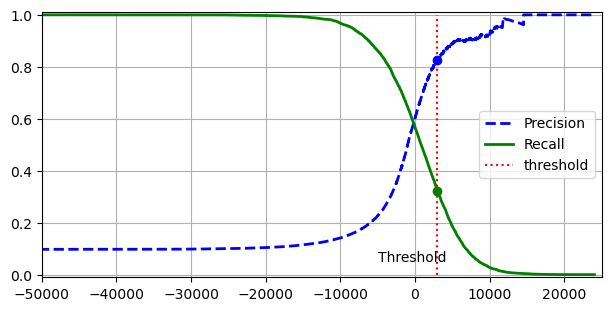

In [20]:
# draw the curves of precision vs. threshold and recall vs. threshold
threshold = 3000
fig2, ax2 = plt.subplots(figsize=(6,3),layout='constrained')
ax2.plot(thresholds,precisions[:-1], 'b--', label='Precision', linewidth=2)
ax2.plot(thresholds,recalls[:-1],'g-', label='Recall', linewidth=2)
ax2.vlines(threshold,0, 1.0, 'r', "dotted", label='threshold')

idx = (thresholds >= threshold).argmax() # first index ≥ threshold
ax2.plot(thresholds[idx], precisions[idx], 'bo')
ax2.plot(thresholds[idx], recalls[idx], 'go')
ax2.grid('on')
ax2.axis([-50000,25000,-0.01,1.01])
ax2.text(-5000,.05, 'Threshold')
ax2.legend(loc='center right')

- A good precision/recall trade-off can also be chosen on the curve of precision vs. recall

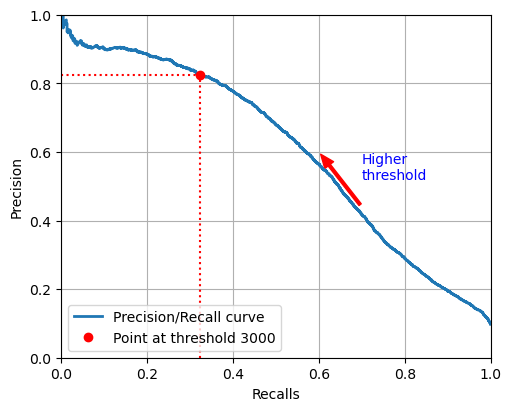

In [21]:
# select a good threshold on the curve of precision vs. recall
fig3, ax3 = plt.subplots(figsize=(5,4),layout='constrained')
ax3.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')

ax3.plot([recalls[idx], recalls[idx]], [0, precisions[idx]], 'r:')
ax3.plot([0, recalls[idx]], [precisions[idx], precisions[idx]], 'r:')
ax3.plot([recalls[idx]], [precisions[idx]], 'ro', label=f'Point at threshold {threshold}')
import matplotlib.patches as mpp
ax3.add_patch(mpp.FancyArrowPatch((0.7,0.44), (0.6,0.6), connectionstyle='arc3,rad=.0',
                                  arrowstyle='Simple, tail_width=2, head_width=8, head_length=10',
                                  color='#ff0000'))
ax3.text(.7,.52,'Higher\nthreshold',color='#0000ff')
ax3.axis([0,1,0,1])
ax3.grid()
ax3.set_xlabel('Recalls')
ax3.set_ylabel('Precision')
ax3.legend(loc='lower left')

- a good Precision/Recall (PR) curve bends toward the top-right corner

In [22]:
# find the threshold giving 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

5562.821942575898

In [23]:
# make predictions and check their precision and recall
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(f'precision={precision_score(y_train_8, y_train_pred_90)}\nrecall={recall_score(y_train_8, y_train_pred_90)}')

precision=0.9
recall=0.15535805845154674


- With 90% precision, however, the recall is too low to be acceptable

[The ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
---
- i.e. the receiver operating characteristic (ROC) curve
  - similar to precision vs. recall curve
- plots *true positive rate (TPR)* (another name for recall) vs. *false positive rate (FPR)*
  - at each threshold
- FPR is also called fall-out

$\displaystyle FPR=\frac{FP}{FP+TN}=1-TNR$ 

$\displaystyle TNR=\frac{TN}{FP+TN}$

In [24]:
# find all fpr and tpr at each threshold
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_8, y_scores)
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

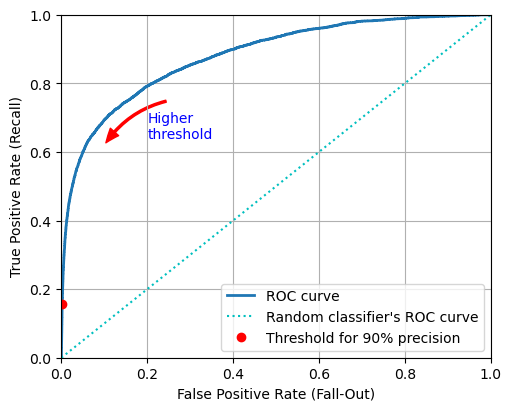

In [25]:
fig4, ax4 = plt.subplots(figsize=(5,4),layout='constrained')
ax4.plot(fpr, tpr, linewidth=2, label='ROC curve')
ax4.plot([0,1],[0,1], 'c:', label="Random classifier's ROC curve")
ax4.plot([fpr_90], [tpr_90], 'ro', label='Threshold for 90% precision')

ax4.add_patch(mpp.FancyArrowPatch((.25,.75),(.1,.62), connectionstyle='arc3,rad=.2',
                                  arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
                                  color='#ff0000'))
ax4.text(.2,.64,"Higher\nthreshold", color='#0000ff')
ax4.axis([0,1,0,1])
ax4.grid()
ax4.set_xlabel('False Positive Rate (Fall-Out)')
ax4.set_ylabel('True Positive Rate (Recall)')
ax4.legend(loc="lower right")


- the ROC curve of a good classifier bends toward the top-left corner
  - trade-off: the higher TPR, the higher FPR
- the metric for classifier related to ROC is the *area under the curve (AUC)*
  - area of 1 means a perfect classifier
  - area of 0.5 means a purely random classifier

In [26]:
# calculate the ROC AUC
from sklearn.metrics import roc_auc_score
print(f'roc auc={roc_auc_score(y_train_8, y_scores)}')

roc auc=0.8818632411939408


Compare SGDClassifier with RandomForestClassifier
---
- classifier can be compared with the evaluation metrics such as
  - Precision/Recall (PR) curve, F1 score, ROC AUC score, etc.
- RandomForestClassifier.predict_proba() calculates class probabilities for each instance
  - the probabilities of the positive class can be used as scores

In [27]:
# train and evaluate a RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=50)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_8, method='predict_proba')

In [28]:
# show the class probabilities for the first 10 images in the training set
# each row: [probability of being negative, probability of being positive]
y_probas_forest[:10]

array([[0.98, 0.02],
       [1.  , 0.  ],
       [0.97, 0.03],
       [1.  , 0.  ],
       [0.98, 0.02],
       [0.94, 0.06],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ]])

In [29]:
# use the estimated probabilities for the positive class as the scores
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_8, y_scores_forest)

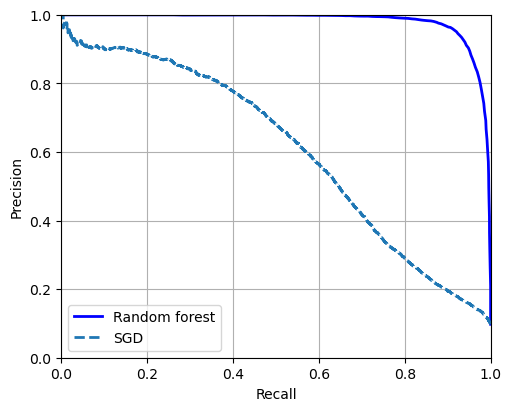

In [30]:
fig5, ax5 = plt.subplots(figsize=(5,4),layout='constrained')
ax5.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label='Random forest')
ax5.plot(recalls, precisions, '--', linewidth=2, label='SGD')

ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.axis([0,1,0,1])
ax5.grid()
ax5.legend(loc='lower left')

-  RandomForestClassifier's PR curve is much better than SGDClassifier's

In [31]:
# calculate RandomForestClassifier's f1 score, roc auc score, precision and recall
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 
print(f'f1 score={f1_score(y_train_8, y_train_pred_forest)}')
print(f'roc auc score={roc_auc_score(y_train_8, y_train_pred_forest)}')
print(f'precision score={precision_score(y_train_8, y_train_pred_forest)}')
print(f'recall score={recall_score(y_train_8, y_train_pred_forest)}')

f1 score=0.8985561248253376
roc auc score=0.9115885082956896
precision score=0.9875102375102375
recall score=0.8243035378567766


- they are all better than SGDClassifier's respective scores

Multiclass Classification
---
- binary classifiers distinguish between two classes
  - such as SGDClassifier and SVC
  - multiple binary classifiers can be combined to classify multiple classes
- multiclass classifiers can distinguish between more than two classes
  - also called multinomial classifiers
  - such as RandomForestClassifier, GaussianNB and LogisticRegression


Two Multiclass Classification Strategies used by Binary Classifier (BC)
---
- one-versus-the-rest (OvR)
   - also called one-versus-all (OvA)
   - needs $M$ BCs, one for each class
   - classify an instance with all classifiers and choose the class output from the classifier with the highest score
   - preferred by most BCs
 - one-versus-one (OvO)
   - train a BC for every pair of classes
   - needs $\displaystyle {{M}\choose{2}}=\frac{M(M-1)}{2}$ BCs
   - each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish
   - mainly used by BCs that scale poorly with the size of the training set
   - rare, such as *support vector machine classifier*
 - scikit runs OvR or OvO automatically for multi-classification with BCs

In [32]:
# Multi-classify 10 digits with SVC
# scikit used the OvO strategy and trained 10*(10-1)/2=45 binary classifiers
# y_train has 10 classes (labels): digit `0` to `9`
from sklearn.svm import SVC

svm_clf = SVC(random_state=50)
svm_clf.fit(X_train[:2000], y_train[:2000]) # choose a small part of the data set

SVC(random_state=50)

In [33]:
# make a prediction on the first 100 digits
svm_predicts = svm_clf.predict(first_100_digits)
print(f'{svm_predicts}\n{svm_predicts==np.array(y_train[:100])}')

['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7' '2' '8'
 '6' '9' '4' '0' '9' '1' '1' '2' '4' '3' '2' '7' '3' '8' '6' '9' '0' '5'
 '6' '0' '7' '6' '1' '8' '7' '9' '3' '9' '8' '5' '5' '3' '3' '0' '7' '4'
 '9' '8' '0' '9' '4' '1' '4' '4' '6' '0' '4' '5' '6' '1' '0' '0' '2' '7'
 '1' '6' '3' '0' '2' '1' '1' '7' '0' '0' '2' '6' '7' '8' '3' '9' '0' '4'
 '6' '7' '4' '6' '8' '0' '7' '8' '3' '1']
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  T

In [34]:
# for each digit, the code made 45 predictions, one per pair of classes, in the background
# the class that won the most duels is selected
# ties are broken with a small algorithmic tweak
# ten scores are returned for each sample, one per class (digit)
first_digit_score = svm_clf.decision_function(first_100_digits[:1])
print(f'10 classes={svm_clf.classes_}\n{first_digit_score.round(2)=}\nthe highest score={first_digit_score.max()}')

10 classes=['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
first_digit_score.round(2)=array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])
the highest score=9.301575971974335


In [35]:
# find the predicted result with code
class_id = first_digit_score.argmax()
svm_clf.classes_[class_id]

'5'

In [36]:
# which strategy, OvO or OvR can be created manually
from sklearn.multiclass import OneVsRestClassifier
# non-binary classifiers can even be used in the constructor
ovr_clf = OneVsRestClassifier(SVC(random_state=50)) 
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=50))

In [37]:
# make a prediction on the first digit
ovr_clf.predict(first_100_digits[:1])

array(['5'], dtype='<U1')

In [38]:
# for OvR, 10 classifiers are trained in the background
ovr_clf.estimators_

[SVC(random_state=50),
 SVC(random_state=50),
 SVC(random_state=50),
 SVC(random_state=50),
 SVC(random_state=50),
 SVC(random_state=50),
 SVC(random_state=50),
 SVC(random_state=50),
 SVC(random_state=50),
 SVC(random_state=50)]

In [39]:
# Train a SGDClassifier on the 10-classes MNIST dataset, 
sgd_mclf = SGDClassifier(random_state=50)
sgd_mclf.fit(X_train, y_train)

SGDClassifier(random_state=50)

In [40]:
# then make a prediction
sgd_mclf.predict(first_100_digits[:1])

array(['3'], dtype='<U1')

In [41]:
# the prediction is wrong, 
# what are the  scores that the SGD classifier assigned to each class
sgd_mclf.decision_function(first_100_digits[:1]).round()

array([[ -8508., -36300., -10348.,   6674., -28386.,   4683., -26720.,
        -13430.,  -6842., -11586.]])

In [42]:
# We may use classifier metrics for an overall evaluation such as accuracy
cross_val_score(sgd_mclf, X_train, y_train, scoring='accuracy')

array([0.889     , 0.855     , 0.84833333, 0.85266667, 0.86816667])

In [43]:
# the accuracy can be improved by simply scaling the inputs
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_stdscaled = std_scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_mclf, X_train_stdscaled, y_train, scoring='accuracy')

array([0.90183333, 0.88625   , 0.894     , 0.89091667, 0.90158333])

Find the way to improve models through Error Analysis
---
- confusion matrix shows misclassification

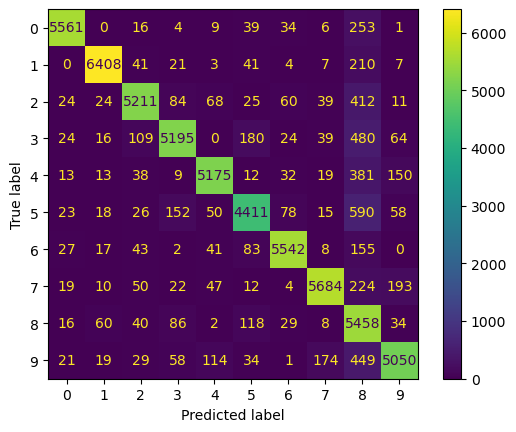

In [44]:
# visualize confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_train_mpred = cross_val_predict(sgd_mclf, X_train_stdscaled, y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_mpred)

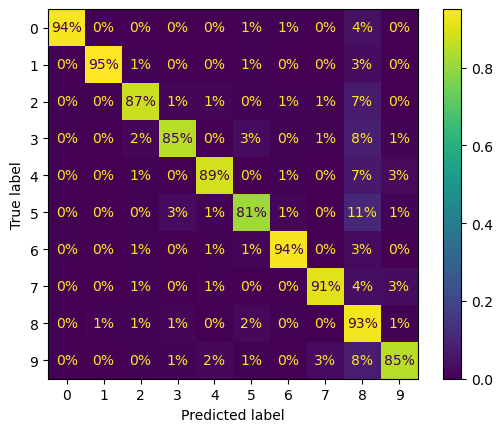

In [45]:
# normalize the confusion matrix by row for better information
# the percentages shown are relative to the total number of predictions of each class
ConfusionMatrixDisplay.from_predictions(y_train, y_train_mpred, normalize='true', values_format='.0%')

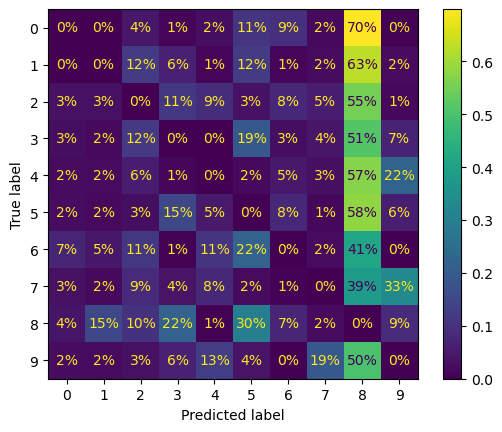

In [46]:
# make the errors stand out by putting zero weight on the correct predictions
# and normalize by row
# each row r means: the percentage of class r being misclassified to other classes
# the percentage p at cell[r,c] means p of `r`'s are misclassified as `c` 
# among all `r`'s misclassifications
error_weight = (y_train_mpred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_mpred, sample_weight=error_weight,
                                        normalize='true', values_format='.0%')

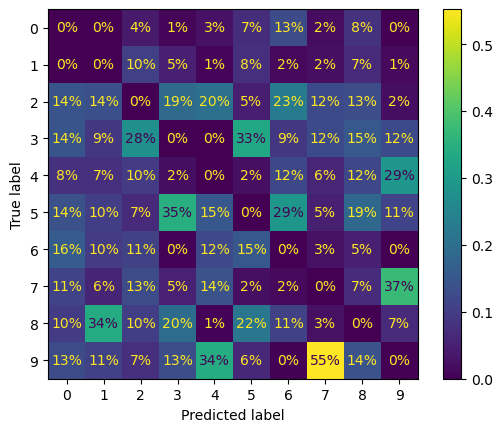

In [47]:
# the confusion matrix can also be normalized by column
# each column c means: the percentage of other classes being misclassified to c
# the percentage p at cell[r,c] means p of misclassified `c`'s are actually `r`'s
error_weight = (y_train_mpred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_mpred, sample_weight=error_weight,
                                        normalize='pred', values_format='.0%')

- the major misclassifications happen between similar digits such as `7` vs. `9`, `3` vs. `5`, `8` vs. `0`
  - new features can be added to improve the model, such as the number of closed loops
    - 0 loop in 7, 1 loop in 9
    - 2 loops in 8, 1 loop in 0
    - how about 3 vs. 5?

Text(0, 0.5, 'True label')

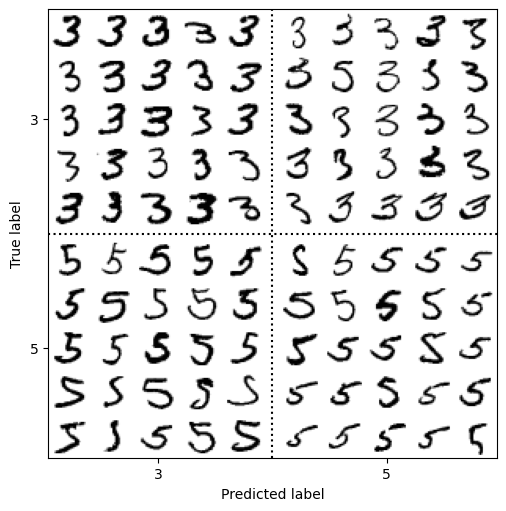

In [48]:
# Let's get insights by plotting examples of '3s' and 5's in a confusion matrix
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_mpred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_mpred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_mpred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_mpred == cl_b)]

size = 5
pad = 0.2
fig6,ax6 = plt.subplots(figsize=(size, size), layout='constrained')
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        ax6.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
ax6.set_xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
ax6.set_yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
ax6.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
ax6.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
ax6.axis([0, 2 * size + pad, 0, 2 * size + pad])
ax6.set_xlabel("Predicted label")
ax6.set_ylabel("True label")


- Most misclassified images seem like obvious errors to a human
  - there are a few hard writings
- The main reason is that SGDClassifier is a simple linear model
  - while human brain is a very complex neuron network
    - enhanced by eyes for image preprocessing
- The main difference between 3s and 5s is the difference between their heads
  - their images can be improved through
    - *image preprocessing*: well-center the images to avoid too much skew
    - *data augmentation*: slightly shift and rotate the training images to generate variants

Multilabel Classification
---
- outputs multiple binary tags for each sample
  - ex. recognize car plates and output whether contain
    - letters
    - digits

In [49]:
# A multilabel classification shows each number:
# label 1: is it large than 5?
# label 2: is it an even number?

from sklearn.neighbors import KNeighborsClassifier
# KNeighborsClassifier supports multilabel classification
# not all classifiers can
y_train_large = (y_train >= '5')
y_train_even = (y_train.astype('int8')%2 == 0)
y_multilabel = np.c_[y_train_large, y_train_even]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [50]:
# predict first 10 digits
knn_preds = knn_clf.predict(first_100_digits[:10])
np.c_[y_train[:10], knn_preds]

array([['5', True, False],
       ['0', False, True],
       ['4', False, True],
       ['1', False, False],
       ['9', True, False],
       ['2', False, True],
       ['1', False, False],
       ['3', False, False],
       ['1', False, False],
       ['4', False, True]], dtype=object)

- A multilabel classifier can be evaluated on each label with the metrics applicable to binary classifiers such as
  - f1 score, accuracy, recall, roc auc, etc.
  - usually the the metrics of these labels are aggregated to average

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel)
# average='macro' means equally weighted average
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9818567434842806

Support multilabel classification with unilabel classifiers
---
- train one unilabel model (such as SVC) per label
  - it is challenging to capture the dependencies between the labels
  - this problem can be solved by chaining the models together
    - each model uses the input features plus all the predictions of its foregoing models 
    - implemented in `ChainClassifier`

In [52]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(),cv=5, random_state=50)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=5, random_state=50)

In [53]:
# make a prediction on the first 10 digits
chain_pred = chain_clf.predict(first_100_digits[:10])
np.c_[y_train[:10], chain_pred]

array([['5', 1.0, 0.0],
       ['0', 0.0, 1.0],
       ['4', 0.0, 1.0],
       ['1', 0.0, 0.0],
       ['9', 1.0, 0.0],
       ['2', 0.0, 1.0],
       ['1', 0.0, 0.0],
       ['3', 0.0, 0.0],
       ['1', 0.0, 0.0],
       ['4', 0.0, 1.0]], dtype=object)

Multioutput Classification
---
- refers to multioutput-multiclass classification
- generalizes multilabel classification so that each label can be multiclass
  - i.e. each label has two and more values


In [54]:
# A multioutput classifier
# - removes noise from images
# - outputs a clean digit image which is a multilabel
#   - one label per pixel
#   - each label has multiple values (pixel intensity 0-255)

# create noisy images from MNIST images
np.random.seed(50)
train_noise = np.random.randint(0,100, (len(X_train), 784))
X_train_obscured = X_train + train_noise
test_noise = np.random.randint(0,100, (len(X_test), 784))
X_test_obscured = X_test + test_noise

# the original MNIST images as the targets
y_train_obscured = X_train
y_test_obscured = X_test

# create and train a multioutput classifier
knn_mclf = KNeighborsClassifier()
knn_mclf.fit(X_train_obscured, y_train_obscured)

KNeighborsClassifier()

In [55]:
# clean the first 10 images in the test set
clean_digits = knn_mclf.predict(X_test_obscured[:10])

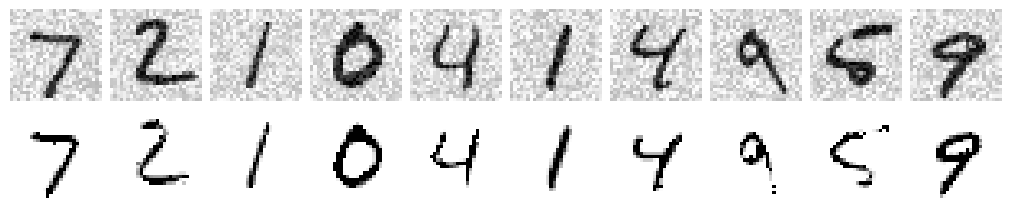

In [56]:
# show obscured digits and clean digits side-by-side
fig7, axs7=plt.subplots(2,10,figsize=(10,2), layout='constrained')
for idx, (obscure_image, clean_image) in enumerate(zip(X_test_obscured[:10], clean_digits)):
  axs7[0, idx].imshow(obscure_image.reshape((28,28)), cmap='binary')
  axs7[0, idx].axis("off")
  axs7[1, idx].imshow(clean_image.reshape((28,28)), cmap='binary')
  axs7[1, idx].axis("off")

# References
- [Model selection and evaluation in scikit](https://scikit-learn.org/stable/model_selection.html)